# Session Objective: Use Pre-Trained Word/Sentence Embedding Models to classify TREC Data

**Overview:** 
In this session we'll try to solve the TREC classification problem by using a few popular Deep Learning Algorithms.
Concretely, we will use pre-trained Language Models to generate **representations(Embeddings)** for our input data and then classify these representations using a shallow neural network.
We will examine the network architectures of **Universal Sentence Encoder(USE)** and **Bidirectional Encoder Representation from Transformers(BERT)** and touch upon the pros and cons of these architectures in classifying TREC data.

### What you'll learn:
- How to use **Keras** for Text classification
- How to use **Tensorflow** for Text classification
- How to generate representations using pre-trained **Universal Sentence Encoder: USE**
- How to tune and evaluate Deep Learning models  
- How to use pre-trained Language Model **Bidirectional Encoder Representation from Transformers: BERT** for Text classification

**Note:** We will be using the same dataset as the previous 2 sessions. Notebook links to the previous session are available **INSERT LINK**

## Utility Functions:
The following two utility functions provide functionality that can be used across different models to inspect training metrics and performance. These will be used at a later point in time.

In [6]:
#Matplotlib Plotting Import
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Function to plot training accuracy/loss, validation accuracy/loss.
    :param history: Keras training history object. See: https://keras.io/callbacks/#history
    """
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [7]:
import numpy as np

#Keras Imports: USE Embedding Classification
from keras.layers import Dense, Input, Dropout
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Sklearn Utility Imports
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

def generate_classification_report(model_path, label_encoder, test_features, test_labels, class_names=None):
    """
    Function to generate SKLearn based multi class classification report
    :param model_path: Path to trained model.
    :param label_encoder: Encoder used during label transformation
    :param test_features: Features for test.
    :param test_labels: Ground truth labels
    :param class_names: Class names for the true and pred integer values
    :return: MultiClass Classification Report
    """
    
    # Load pre-trained model
    model = load_model(model_path)
    
    # Predict labels for test features
    preds = model.predict(test_features)
    
    # Since the model is trained to return a set of probabilities across the label set, 
    # we'll have to find the index of label set with the highest probability score.
    preds_index = np.argmax(preds, axis=1)
    
    # Converting the predicted index into the original TREC based label
    preds_labels = label_encoder.inverse_transform(preds_index)
    
    return classification_report(test_labels, preds_labels, target_names=label_encoder.classes_)

<h3> Download Data </h3><div>
    First let's download the train and test data from Xin Li, Dan Roth, Learning Question Classifiers. COLING'02, Aug., 2002.
    <a href="https://cogcomp.seas.upenn.edu/Data/QA/QC/">https://cogcomp.seas.upenn.edu/Data/QA/QC/</a>
</div>
<br>
<div>We will store these data in Pandas DataFrames (and write them as .csv files) containing the following columns:
    <br>
    <ul>
        <li><em>question</em>: The question text</li>
        <li><em>coarse_label</em>: The coarse-grained label (6 classes)</li>
        <li><em>label</em>: The fine-grained label</li>
    </ul>
    Finally, we will process every sentence into SpaCy Documents, and save them in a new column, "processed_question".
</div>

In [8]:
import os
import pandas as pd
from download_data import main as download_trec_data

if not os.path.exists("data"):
    download_trec_data()

path_to_train = os.path.join("data", "train.csv")
path_to_test = os.path.join("data", "test.csv")

train_df = pd.read_csv(os.path.join("data", "train.csv"))
test_df = pd.read_csv(os.path.join("data", "test.csv"))

## Universal Sentence Encoder
<u>Reference Paper</u>: https://arxiv.org/abs/1803.11175<br>
<u>Announcement</u>: https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html<br><br>
**Universal Sentence Encoder (USE)** is a versatile sentence embedding model that convert sentences into vector representations. These vectors capture rich semantic information that can be used to train classifiers for a broad range of downstream tasks.

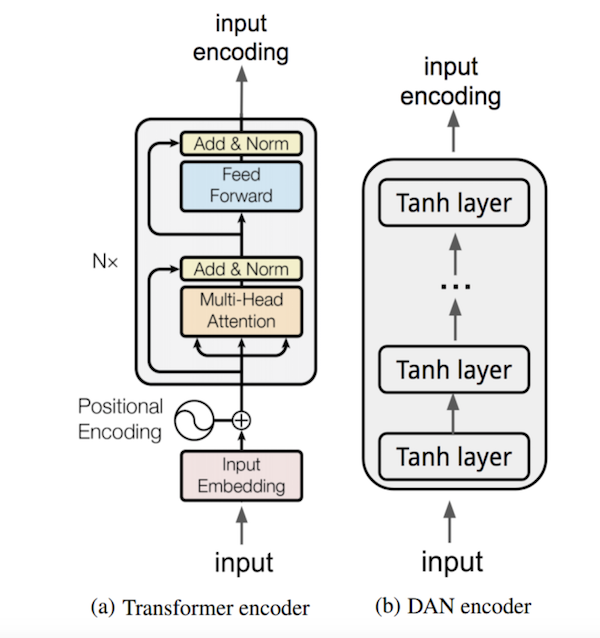

Note: USE can work on small multi sentence paragraphs.


### High level steps for classifying text using pre-trained USE model: 
- Download Pre-trained USE Model from Tensorflow HUB<br>
- Extract USE Repesentations for both train and test sets<br>
- Define a the classification network architecture<br>
- Start Training


## Data Prep for USE Q&A classification

In [49]:
import re
def pre_process_text(input_text):
    """
    Function to normalize text by applying NLP tranformations.
    :param input_text: Question text from the input sample 
    """
    #Exercise: build multiple models based on diferrent pre-processing techniques.
    #Un-Comment the below line to see if the model performance improves by introducing additional 
    #input_text = re.sub('[^A-Za-z0-9 ,\?\'\"-._\+\!/\`@=;:]+', '', input_text)
    return input_text.lower()

##### Extract the raw question text and labels from the training and test dataframes:

In [21]:
features_train = train_df['question'].to_list()
features_test  = test_df['question'].to_list()
labels_train   = train_df['coarse_label'].to_list()
labels_test    = test_df['coarse_label'].to_list()

##### Pre-Process the text used for training and test

In [22]:
# Pre-Process the text used for training and test
features_train_processed = list(map(lambda x:pre_process_text(x), features_train))
features_test_processed = list(map(lambda x:pre_process_text(x), features_test))

###### The labels for the training and test set are in a string format (eg: ABBR, DESC etc). These labels need to be converted into a numerical set using SKLearn's Label Encoder See:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [23]:
# Pre-Process labels for training
label_encoder = preprocessing.LabelEncoder()
labels_train_tranformed = label_encoder.fit_transform(labels_train)
labels_train_categorical = to_categorical(np.asarray(labels_train_tranformed))
# Note: We do not have to "fit" the label encoder for the test set since they already have been fit on the trainset
labels_test_transformed = label_encoder.transform(labels_test)
labels_test_categorical = to_categorical(np.asarray(labels_test_transformed))

##### Download and load the pre-trained Universal Sentence Encoder from Tensorflow Hub

In [24]:
#Tensorflow Imports
import tensorflow as tf
import tensorflow_hub as hub

pre_trained_use_embed_model = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

##### Generate sentence/phrase representations of the training and test text data using the above downloaded USE model

In [25]:
embeddings_features_train = []
embeddings_features_test = []
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    embeddings_features_train.append(session.run(pre_trained_use_embed_model(features_train_processed)))
    embeddings_features_test.append(session.run(pre_trained_use_embed_model(features_test_processed)))

In [26]:
# Inspect the shape of the input embeddings
question_embeddings_train = embeddings_features_train[0]
question_embeddings_test = embeddings_features_test[0]

In [27]:
# Inspect the shape of the input embeddings
question_embeddings_train.shape[1]

512

## Model Definition for USE Q&A classification

We will use the Keras Functional API to build and train the USE Q&A classifier network. See https://keras.io/getting-started/functional-api-guide/#first-example-a-densely-connected-network

In [50]:
class QNAClassifier():
    """
    Q&A classifier class using Keras framework
    """
    
    def __init__(self, experiment_name):
        """
        :param experiment_name: Name of the experiment. This will be used to name the model checkpoints.
        """
        
        #Exercise: Modify the below hyper parameters to create variations of the USE Q&A classifier model.
        self.patience = 10
        self.epochs = 100
        self.batch_size = 64
        
        self.experiment_name = experiment_name
        self.output_dir = 'models'
        self.class_count = 6
        self.model = None
        
        # Creating an output directory for the generated models.
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    
    def train_vanilla_nn(self, embeddings_train, labels_train, embeddings_test, labels_test):
        """
        Simple Feed forward neural network with 1 Dense layer to classify Q&A embeddings.
        :param embeddings_train: USE embedding repesentation of the training set.
        :param labels_train: Categorical encoded labels for the training set. 
        :param embeddings_test: USE embedding repesentation of the test set.
        :param labels_test: Categorical encoded labels for the test set.
        """
        
        # Network Architecture: Input Layer(Embeddings)-> Dense Layer -> Softmax layer
        # Exercise: Change the size of the hidden layer and the activation unit.
        embedding_inputs = Input(shape=(embeddings_train.shape[1],))
        x = Dense(256, activation='relu')(embedding_inputs)
        predictions = Dense(self.class_count, activation='softmax')(x)
        
        self.model = Model(inputs=embedding_inputs, outputs=predictions)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        
        # Keras Callbacks
        early_stopping = EarlyStopping(monitor='val_acc', patience=self.patience)
        model_filename = self.output_dir + "/" + self.experiment_name
        checkpoint = ModelCheckpoint(model_filename + '.{epoch:03d}-{val_acc:.4f}.hdf5',
                                     monitor='val_acc', verbose=1,
                                     save_best_only=True, mode='auto')
        
        # Start Training
        training_history = self.model.fit(embeddings_train, labels_train, 
                                          validation_data = (embeddings_test, labels_test),
                                          epochs= self.epochs,
                                          batch_size=self.batch_size,
                                          callbacks=[checkpoint, early_stopping])
        
        return training_history
    
    def train_vanilla_nn_cross_validated(self, embeddings_train, labels_train, embeddings_test, labels_test):
        """
        K-Fold Cross validated simple Feed forward neural network with 1 Dense layer to classify Q&A embeddings.
        :param embeddings_train: USE embedding repesentation of the training set.
        :param labels_train: Categorical encoded labels for the training set. 
        :param embeddings_test: USE embedding repesentation of the test set.
        :param labels_test: Categorical encoded labels for the test set.
        """

        # Network Architecture: Input Layer(Embeddings)-> Dense Layer -> Softmax layer
        # Exercise: Change the size of the hidden layer and the activation unit.
        embedding_inputs = Input(shape=(embeddings_train.shape[1],))
        x = Dense(64, activation='relu')(embedding_inputs)
        predictions = Dense(self.class_count, activation='softmax')(x)
        
        self.model = Model(inputs=embedding_inputs, outputs=predictions)
        self.model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
        
        early_stopping = EarlyStopping(monitor='val_acc', patience=self.patience)
        
        training_histories = []
        counter = 0
        
        #Exercise: Experiment with different number of splits.
        kf = KFold(n_splits=3, random_state=42, shuffle=False)
        for train_index, test_index in kf.split(embeddings_train):
            
            X_train, X_test = embeddings_train[train_index], embeddings_train[test_index]
            y_train, y_test = labels_train[train_index], labels_train[test_index]
            
            model_filename = self.output_dir + "/" + self.experiment_name + "_fold{}".format(counter)
            checkpoint = ModelCheckpoint(model_filename + '.{epoch:03d}-{val_acc:.4f}.hdf5',
                                         monitor='val_acc', verbose=1,
                                         save_best_only=True, mode='auto')
        
            # Start Training
            training_history = self.model.fit(X_train, y_train, 
                                              validation_data = (X_test, y_test),
                                              epochs= self.epochs,
                                              batch_size=self.batch_size,
                                              #Exercise: Add Tensorboard here
                                              callbacks=[checkpoint, early_stopping])
            
            print("-----------------------------\n")
            print("KSplit {} training complete\n".format(counter))
            print("-----------------------------\n")
            
            counter += 1
            
            training_histories.append(training_history)
        
        return training_histories
    
    def train_tuned_nn(self, embeddings_train, labels_train, embeddings_test, labels_test):
        
        """
        Tuned Feed forward neural network with 1 Dense layer to classify Q&A embeddings.
        :param embeddings_train: USE embedding repesentation of the training set.
        :param labels_train: Categorical encoded labels for the training set. 
        :param embeddings_test: USE embedding repesentation of the test set.
        :param labels_test: Categorical encoded labels for the test set.
        """
        embedding_inputs = Input(shape=(embeddings_train.shape[1],))
        x = Dense(128, activation='relu')(embedding_inputs)
        # Added dropouts for regularization
        # Exercise: Change the value of dropouts.
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        predictions = Dense(self.class_count, activation='softmax')(x)
        
        model = Model(inputs=embedding_inputs, outputs=predictions)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        
        # Keras Callbacks
        early_stopping = EarlyStopping(monitor='val_acc', patience=self.patience)
        model_filename = self.output_dir + "/" + self.experiment_name
        checkpoint = ModelCheckpoint(model_filename + '.{epoch:03d}-{val_acc:.4f}.hdf5',
                                     monitor='val_acc', verbose=1,
                                     save_best_only=True, mode='auto')
        
        
        # Start Training
        training_history = model.fit(embeddings_train, labels_train, 
                                     validation_data = (embeddings_test, labels_test),
                                     epochs= self.epochs,
                                     batch_size=self.batch_size,
                                     #Exercise: Add Tensorboard here
                                     callbacks=[checkpoint, early_stopping])
        
        return training_history

##### Train Vanilla Neural Network with Pre-trained USE Embeddings

In [51]:
# Train Vanilla Neural Network with Pre-trained USE Embeddings
use_embedding_classifier = QNAClassifier("USE_Embedding_Model")
use_embedding_training_history = use_embedding_classifier.train_vanilla_nn(question_embeddings_train, labels_train_categorical,
                                                                          question_embeddings_test, labels_test_categorical)

Train on 5452 samples, validate on 500 samples
Epoch 1/100
5452/5452 [==============================] - 7s 1ms/step - loss: 1.0589 - acc: 0.6843 - val_loss: 0.5197 - val_acc: 0.8700

Epoch 00001: val_acc improved from -inf to 0.87000, saving model to models/USE_Embedding_Model.001-0.8700.hdf5
Epoch 2/100
5452/5452 [==============================] - 0s 38us/step - loss: 0.5523 - acc: 0.8091 - val_loss: 0.3952 - val_acc: 0.8680

Epoch 00002: val_acc did not improve from 0.87000
Epoch 3/100
5452/5452 [==============================] - 0s 38us/step - loss: 0.4654 - acc: 0.8314 - val_loss: 0.3432 - val_acc: 0.8760

Epoch 00003: val_acc improved from 0.87000 to 0.87600, saving model to models/USE_Embedding_Model.003-0.8760.hdf5
Epoch 4/100
5452/5452 [==============================] - 0s 38us/step - loss: 0.4296 - acc: 0.8478 - val_loss: 0.3222 - val_acc: 0.8840

Epoch 00004: val_acc improved from 0.87600 to 0.88400, saving model to models/USE_Embedding_Model.004-0.8840.hdf5
Epoch 5/100
5452/

##### Plot training history of above Vanilla Neural Network with Pre-trained USE Embeddings

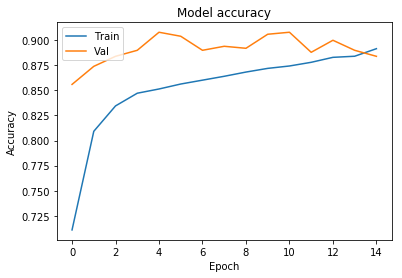

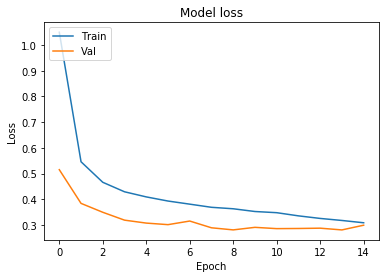

In [35]:
plot_training_history(use_embedding_training_history)

##### Train Cross Validated Vanilla Neural Network with Pre-trained USE Embeddings

In [53]:
# Train Cross Validated Vanilla Neural Network with Pre-trained USE Embeddings
use_embedding_classifier = QNAClassifier("USE_Embedding_CV_Model")
use_embedding_training_history = use_embedding_classifier.train_vanilla_nn_cross_validated(question_embeddings_train, labels_train_categorical,
                                                                                           question_embeddings_test, labels_test_categorical)

Train on 3634 samples, validate on 1818 samples
Epoch 1/100
3634/3634 [==============================] - 7s 2ms/step - loss: 1.3444 - acc: 0.5889 - val_loss: 1.0346 - val_acc: 0.7459

Epoch 00001: val_acc improved from -inf to 0.74587, saving model to models/USE_Embedding_CV_Model_fold0.001-0.7459.hdf5
Epoch 2/100
3634/3634 [==============================] - 0s 32us/step - loss: 0.8633 - acc: 0.7713 - val_loss: 0.7447 - val_acc: 0.7827

Epoch 00002: val_acc improved from 0.74587 to 0.78273, saving model to models/USE_Embedding_CV_Model_fold0.002-0.7827.hdf5
Epoch 3/100
3634/3634 [==============================] - 0s 30us/step - loss: 0.6631 - acc: 0.7969 - val_loss: 0.6267 - val_acc: 0.7866

Epoch 00003: val_acc improved from 0.78273 to 0.78658, saving model to models/USE_Embedding_CV_Model_fold0.003-0.7866.hdf5
Epoch 4/100
3634/3634 [==============================] - 0s 31us/step - loss: 0.5665 - acc: 0.8137 - val_loss: 0.5600 - val_acc: 0.8009

Epoch 00004: val_acc improved from 0.78

3634/3634 [==============================] - 0s 28us/step - loss: 0.2860 - acc: 0.8935 - val_loss: 0.4579 - val_acc: 0.8361

Epoch 00038: val_acc did not improve from 0.83883
-----------------------------

KSplit 0 training complete

-----------------------------

Train on 3635 samples, validate on 1817 samples
Epoch 1/100
3635/3635 [==============================] - 0s 29us/step - loss: 0.3687 - acc: 0.8641 - val_loss: 0.2856 - val_acc: 0.8998

Epoch 00001: val_acc improved from -inf to 0.89983, saving model to models/USE_Embedding_CV_Model_fold1.001-0.8998.hdf5
Epoch 2/100
3635/3635 [==============================] - 0s 29us/step - loss: 0.3536 - acc: 0.8735 - val_loss: 0.2971 - val_acc: 0.8927

Epoch 00002: val_acc did not improve from 0.89983
Epoch 3/100
3635/3635 [==============================] - 0s 31us/step - loss: 0.3420 - acc: 0.8751 - val_loss: 0.3048 - val_acc: 0.8927

Epoch 00003: val_acc did not improve from 0.89983
Epoch 4/100
3635/3635 [==============================] -

##### Train Tuned Neural Network with Pre-trained USE Embeddings

In [55]:
# Train Tuned Neural Network with Pre-trained USE Embeddings
use_embedding_tuned_classifier = QNAClassifier("USE_Embedding_Tuned_Model")
use_embedding_tuned_training_history = use_embedding_tuned_classifier.train_tuned_nn(question_embeddings_train, labels_train_categorical,
                                                                          question_embeddings_test, labels_test_categorical)

W1017 07:55:28.896774 139704171878208 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 5452 samples, validate on 500 samples
Epoch 1/100
5452/5452 [==============================] - 8s 1ms/step - loss: 1.1803 - acc: 0.5633 - val_loss: 0.4959 - val_acc: 0.8800

Epoch 00001: val_acc improved from -inf to 0.88000, saving model to models/USE_Embedding_Tuned_Model.001-0.8800.hdf5
Epoch 2/100
5452/5452 [==============================] - 0s 37us/step - loss: 0.6197 - acc: 0.7771 - val_loss: 0.3872 - val_acc: 0.8700

Epoch 00002: val_acc did not improve from 0.88000
Epoch 3/100
5452/5452 [==============================] - 0s 36us/step - loss: 0.5246 - acc: 0.8105 - val_loss: 0.3869 - val_acc: 0.8640

Epoch 00003: val_acc did not improve from 0.88000
Epoch 4/100
5452/5452 [==============================] - 0s 37us/step - loss: 0.4883 - acc: 0.8236 - val_loss: 0.3221 - val_acc: 0.8900

Epoch 00004: val_acc improved from 0.88000 to 0.89000, saving model to models/USE_Embedding_Tuned_Model.004-0.8900.hdf5
Epoch 5/100
5452/5452 [==============================] - 0s 37us/step

##### Plot training history of above Tuned Neural Network with Pre-trained USE Embeddings

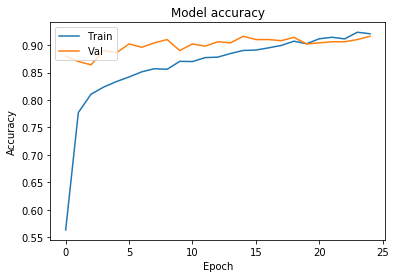

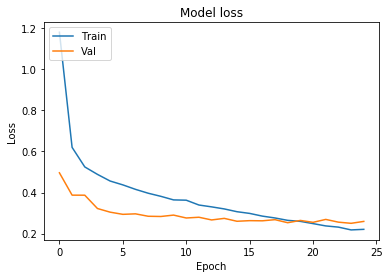

In [56]:
plot_training_history(use_embedding_tuned_training_history)

##### Plot the test classification metrics for the above Tuned Neural Network with Pre-trained USE Embeddings

In [57]:
# Note: Please use the appropriate model path corresponding to your training step.
print(generate_classification_report(model_path = 'models/USE_Embedding_Tuned_Model.011-0.9140.hdf5', 
                                     label_encoder = label_encoder,
                                     test_features = question_embeddings_test,
                                     test_labels = labels_test))

              precision    recall  f1-score   support

        ABBR       1.00      0.89      0.94         9
        DESC       0.91      0.91      0.91       138
        ENTY       0.83      0.82      0.82        94
         HUM       0.94      0.97      0.95        65
         LOC       0.97      0.90      0.94        81
         NUM       0.93      0.97      0.95       113

    accuracy                           0.91       500
   macro avg       0.93      0.91      0.92       500
weighted avg       0.91      0.91      0.91       500



<H2> BERT: Bidirectional Encoder Representation from Transformers </H2>
<u>Refrence Paper</u>: https://arxiv.org/abs/1810.04805<br>
<u>Announcement</u>: https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html

**BERT** is the current state of the art Language Model and is designed by pre-training deep bidirectional representations from unlabeled(Wikipedia)text by jointly conditioning on both left and right context in all layers.
BERT’s model architecture is a multi-layer/stacked set of bidirectional Transformers with the following 2 variants:
**BERTBASE** (L=12, H=768, A=12, Total Parameters=110M) and **BERTLARGE** (L=24, H=1024, A=16, Total Parameters=340M).

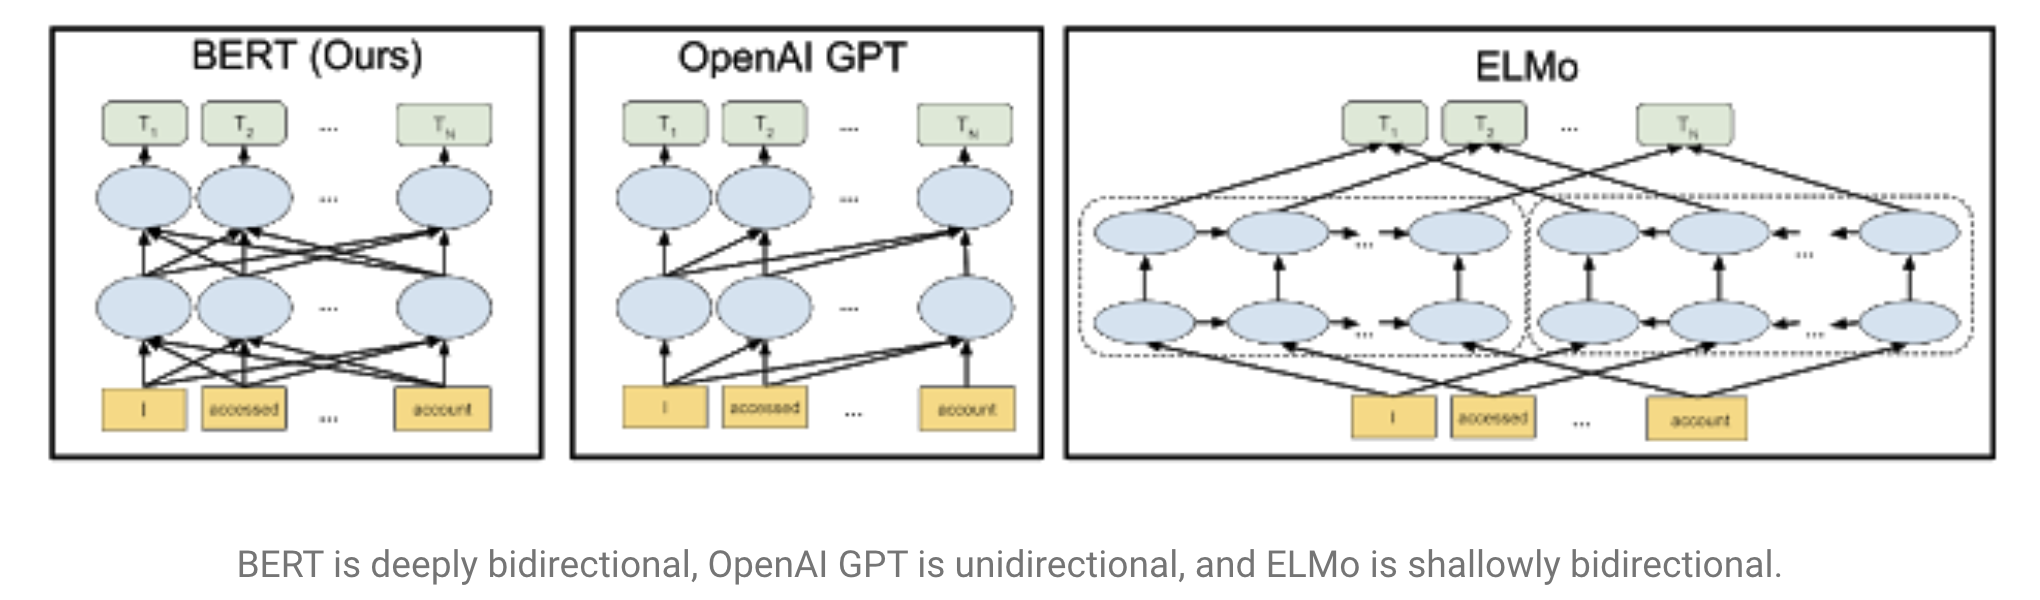


<h3>Data Prep for BERT Q&A classification</h3>

Since BERT is a pre-trained Langauage Model, fine-tuning tasks using BERT is expected to have the same input format of data as that of BERT's training. In a nutshell, we'll have to apply the following transformations to our input text to conform to BERT's fine tuning input expectation.
    
- Lowercase our text (if we're using a BERT lowercase model)<br>
- Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])<br>
- Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])<br>
- Map our words to indexes using a vocab file that BERT provides<br>
- Add special "CLS" and "SEP" tokens for NextSentenceIdentication (see the Section 3 https://arxiv.org/pdf/1810.04805.pdf)<br>
- Append "index" and "segment" tokens to each input (see the Section 3 https://arxiv.org/pdf/1810.04805.pdf)<br>


In [61]:
#BERT Imports: BERT Classification
import bert
import tf_metrics
from bert import run_classifier
from bert import optimization
from bert import tokenization

##### Fortunately, there are multiple libraries that'll trannsform our raw Question text to a format that BERT understands
**bert.run_classifier.InputExample** is a data structure that will store the tranformed Quesstion text into BERT Input format. The below lambda section is only initializing these BERT Input format data structures.

In [63]:
train_InputSamples = list(map(lambda x,y: bert.run_classifier.InputExample(guid=None, text_a=x, text_b=None, label=y),
                              features_train, labels_train))
test_InputSamples = list(map(lambda x,y: bert.run_classifier.InputExample(guid=None, text_a=x, text_b=None, label=y),
                              features_test, labels_test))

##### Download the pre-trained BERT base model and load up the BERT tokenizers to operate on our transformed Question text

In [64]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
tf.logging.set_verbosity(tf.logging.INFO)

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

I1017 15:23:43.534936 139704171878208 saver.py:1499] Saver not created because there are no variables in the graph to restore
W1017 15:23:44.010399 139704171878208 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



##### Time to run the pre-trained BERT tokenizer on our input Question text

In [65]:
# This is the max length of tokens in our Question text dataset
# Exercise: Modify this MAX_SEQ_LENGTH value to see how it affects the training process
MAX_SEQ_LENGTH = 20
label_list = list(set(labels_train))

train_features = bert.run_classifier.convert_examples_to_features(train_InputSamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputSamples, label_list, MAX_SEQ_LENGTH, tokenizer)

W1017 15:23:46.341276 139704171878208 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/bert/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

I1017 15:23:46.342230 139704171878208 run_classifier.py:774] Writing example 0 of 5452
I1017 15:23:46.343018 139704171878208 run_classifier.py:461] *** Example ***
I1017 15:23:46.343504 139704171878208 run_classifier.py:462] guid: None
I1017 15:23:46.343997 139704171878208 run_classifier.py:464] tokens: [CLS] how did ser ##f ##dom develop in and then leave russia ? [SEP]
I1017 15:23:46.344503 139704171878208 run_classifier.py:465] input_ids: 101 2129 2106 14262 2546 9527 4503 1999 1998 2059 2681 3607 1029 102 0 0 0 0 0 0
I1017 15:23:46.345074 139704171878208 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
I1017 15:23:46.345562 139704171878208 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0


### Model Definition for BERT Q&A classification

We'll use Tensorflow's Estimator API/Framework to train our fine-tuned BERT Q&A classification network. See https://www.tensorflow.org/guide/estimator

In [66]:
def bert_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
  """
  Our Custom fine-tuning Q&A classifier definition using BERT output layers.
  :param: is_predicting: Boolean variable to indicate Training or Prediction mode
  :param: input_ids: BERT vocab token index for the input sample
  :param: input_mask: Flag to indicate if the input token is masked (1: Yes, 0:No)
  :param: segment_ids: Flag to indicate which sentence the token belongs to. (0: 1st sentence, 1:2nd sentence)
  :param: labels: Classification label for the input
  :param: num_labels: Total number of labels
  """
  
  bert_module = hub.Module( BERT_MODEL_HUB,trainable=True)
  bert_inputs = dict( input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
  bert_outputs = bert_module(inputs=bert_inputs, signature="tokens", as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Tunable layer.
  output_weights = tf.get_variable("output_weights", [num_labels, hidden_size],
                                   initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable("output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
        return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

##### Estimator driver logic for Training, Evaluation and Predict modes

In [67]:
def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
    """
    Estimator driver logic for Training, Evaluation and Predict modes
    :param: num_labels : Total number of labels
    :param: learning_rate : Learning rate for underlying neural network
    :param: num_train_steps: Number of steps to train (Sample Size/(Batch Size*Number of Epochs))
    :param: num_warmup_steps: Dynamic learning rate adjustment proportion
    """

    def model_fn(features, labels, mode, params):
        """
        Definition for Training, Evaluation and Predict modes
        :param: features: Training/Test features
        :param: labels: Train/Test labels
        :param: mode: Train/Eval/Predict
        :param: params: Dict with training hyperparams
        """

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            # Get BERT model definition
            (loss, predicted_labels, log_probs) = bert_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics.
            def metric_fn(label_ids, predicted_labels):
                """
                Function to calculate training/evaluation metrics
                """
                
                recall = tf.metrics.recall(label_ids, predicted_labels)
                precision = tf.metrics.precision(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(label_ids, predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids, predicted_labels)
                false_pos = tf.metrics.false_positives(label_ids, predicted_labels)
                false_neg = tf.metrics.false_negatives(label_ids, predicted_labels)
                
                return {
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = bert_model(is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
                'probabilities': log_probs,
                'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn


##### Define hyperparameters for training

In [68]:
# Exercise: Modify the below values and observe the change in the training process
# Compute train and warmup steps from batch size
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 5.0
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 10
SAVE_SUMMARY_STEPS = 10

In [317]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [318]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(model_dir='models',
                                    save_summary_steps=SAVE_SUMMARY_STEPS,
                                    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [319]:
model_fn = model_fn_builder(num_labels=len(label_list), learning_rate=LEARNING_RATE,
                            num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config, params={"batch_size": BATCH_SIZE})

I1017 05:43:32.557364 140417880749888 estimator.py:209] Using config: {'_model_dir': 'models', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 10, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1c75d49e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [320]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder( features=train_features, seq_length=MAX_SEQ_LENGTH,
                                                      is_training=True, drop_remainder=False)

##### Start Training

In [321]:
print('Start Training')
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("End Training")

I1017 05:43:39.209364 140417880749888 estimator.py:360] Skipping training since max_steps has already saved.


Start Training
End Training


##### Visualize the training metrics on the Tensorboard

In [338]:
import tensorboard
!tensorboard --logdir .

OSError: Background processes not supported.

##### Evaluate the trained model

In [322]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH,
                                                is_training=False, drop_remainder=False)

In [328]:
metrics = estimator.evaluate(input_fn=test_input_fn, steps=None)
metrics["accuracy"] = (metrics["true_positives"] + metrics["true_negatives"])/(metrics["true_positives"] + metrics["true_negatives"]+metrics["false_positives"] + metrics["false_negatives"])
metrics["f1_score"] = (2*metrics["precision"]*metrics["recall"])/(metrics["precision"]+metrics["recall"])

I1017 05:48:41.761738 140417880749888 estimator.py:1145] Calling model_fn.
I1017 05:48:45.321069 140417880749888 saver.py:1499] Saver not created because there are no variables in the graph to restore
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
I1017 05:48:54.931063 140417880749888 estimator.py:1147] Done calling model_fn.
I1017 05:48:54.952990 140417880749888 evaluation.py:255] Starting evaluation at 2019-10-17T05:48:54Z
I1017 05:48:56.421929 140417880749888 monitored_session.py:240] Graph was finalized.
I1017 05:48:56.424534 140417880749888 saver.py:1280] Restoring parameters from models/model.ckpt-425
I1017 05:48:58.990352 140417880749888 session_manager.py:500] Running local_init_op.
I1017 05:48:59.247173 14041788074

In [329]:
metrics

{'false_negatives': 2.0,
 'false_positives': 1.0,
 'loss': 0.12509353,
 'precision': 0.99760765,
 'recall': 0.99522674,
 'true_negatives': 80.0,
 'true_positives': 417.0,
 'global_step': 425,
 'accuracy': 0.994,
 'f1_score': 0.9964158021312434}